# Data Transformations & Imputation

#### The Variables in this model will be Handled through analysis in the following manner:

- Binary: No manipulation, only translation to true binary
- Nominal: Will be transformed with one-hot encoding
- Ordinal: Object ordinal columns will be transformed into a rating scaled from None -> 0 and Best -> N
- Numerical: Will be transformed into z-scores following the distribution \of the column itself 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import model_selection #import train_test_split
from sklearn import linear_model #LinearRegression
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('../datasets/train-cleaned.csv', index_col=0)

In [3]:
data = data[data.columns[2:]]

#### Loading Metadata to organize transformations:

In [4]:
metadata = pd.read_csv('../datasets/metadata-cleaned.csv', index_col=0)

In [5]:
metadata = metadata[(metadata.column_name != 'id')]

In [6]:
metadata = metadata[(metadata.column_name != 'pid')]

In [7]:
metadata = metadata.reset_index(drop=True)

In [8]:
all_nominals_names = metadata[metadata.variable_type == 'Nominal']

In [9]:
nominals = data[all_nominals_names.column_name]

In [10]:
numeric_names = metadata[metadata.variable_type == 'Numerical']

In [11]:
numerics = data[numeric_names.column_name]

### Transform Method from Ordinal Null Handling

- Because I began 'Null Handling' on the data cleaning Jupyter Lab document, \
I will first finish the process of Transforming the remainder of the ordinal values to remain organized

In [12]:
def ord_transform(df, col, transform):
    '''ord method'''
    assert transform
    #df[col] = [transform[x] for x in df[col]]
    df[col] = df[col].map(transform)

    metadata.loc[metadata['column_name'] == col, 'ord_transform_map'] = str(transform)
    return df

- As what can be noticed from the above, there are duplicate functions across the notebook. 
- One way that I can definitely improve going forward is to build with classes to more easily re-use code

In [13]:
def check_if_transformed(variable):
    '''ord method'''
    if metadata.loc[metadata['column_name'] == variable, 'ord_transform_map'].isnull().all():
        return False
    else:
        return True

In [14]:
def mark_dont_transform(variable):
    '''ord method'''
    metadata.loc[metadata['column_name'] == variable, 'ord_transform_map'] = 'No Transform'

In [15]:
popular_ord_transform = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa': 2, 'Po' : 1, np.nan: 0} 
garage_finish_dict = {'Fin':3,'RFn': 2, 'Unf':1, np.nan: 0}
basement_finish_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1, np.nan:0}
basement_exp_dict = {'Gd':3,'Av':2,'Mn':1, 'No':0, np.nan:0}
slope_dict = {'Gtl':3, 'Mod':2, 'Sev':1}
countour_dict = {'Lvl':4, 'Low':3, 'Bnk':2,'HLS':1}
lot_shape_dict = {'Reg':4,'IR1':3,'IR2':2,'IR3':1}
functional_dict = {
    "Typ": 1,
    "Min1": 2,
    "Min2": 3,
    "Mod": 4,
    "Maj1": 5,
    "Maj2": 6,
    "Sev": 7,
    "Sal": 8}
binary_dict = {'Y':1,'N':0}

- One aspect of this project that made my approach more challenging was the handling of ordinal variables
- Though sklearn provides a few methods to automatically handle ordinal data to make transformations\
some of these orderings required a judgement call that I didn't want to leave to a library
- In the future, one way to improve this method would be to store this dictionary in a text file perhaps. Though there could be some value in being able to read the dictionaries here

In [16]:
ordinal_names = metadata[metadata.variable_type == 'Ordinal']

In [17]:
ordinals = data[ordinal_names.column_name]

In [18]:
for var in ordinals.columns:
    if data[var].dtype == 'int64':
        mark_dont_transform(var)

In [19]:
def get_ordinals_untransformed():
    output = []
    for col in ordinals.columns:
        if not check_if_transformed(col):
            output.append((col,data[col].unique()))
    return output

### Applying all Translations Transformations to ordinal data

- The transformations below required a large amount of manual work, looking forward, I believe it will be most useful to find an automated way of sorting and ordering ordinal data

In [20]:
data = ord_transform(data,'exter_cond',popular_ord_transform)

In [21]:
data = ord_transform(data,'heating_qc',popular_ord_transform)

In [22]:
data = ord_transform(data,'exter_qual',popular_ord_transform)

In [23]:
data = ord_transform(data,'kitchen_qual',popular_ord_transform)

In [24]:
data = ord_transform(data,'land_slope',slope_dict)

In [25]:
data = ord_transform(data,'land_contour',countour_dict)

In [26]:
data = ord_transform(data,'lot_shape',lot_shape_dict)

In [27]:
data = ord_transform(data,'paved_drive',{'Y':3,'P':2,'N':1})

In [28]:
data = ord_transform(data,'functional',functional_dict)

In [29]:
data = ord_transform(data,'central_air',binary_dict)

In [30]:
X = data[data.columns[:-1]]

In [31]:
y = data[data.columns[-1]]

#### Splitting Training and Testing

In [32]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y)

### Data Imputing (following the explanations included at the top of this Page)

In [33]:
def impute(column_names, task, xtrain, xtest):
    for col in column_names:
        if task == 'impute_mean':
            impute_item = xtrain[col].mean()
        elif task == 'impute_median':
            impute_item = xtrain[col].median()
        elif task == 'impute_mode':
            impute_item = xtrain[col].mode().iloc[0]
        else:
            raise Exception('insert verified task')
        xtrain[col] = xtrain[col].fillna(impute_item)
        if xtest is not None:
            xtest[col] = xtest[col].fillna(impute_item) 
    return(xtrain,xtest)

#### Applying all transformations to both the testing and training sets

In [34]:
mean_cols = metadata[metadata['impute_mean'] == 1].column_name.values

In [35]:
x_train, x_test = impute(mean_cols,'impute_mean',x_train,x_test)

In [36]:
mode_cols = metadata[metadata['impute_mode'] == 1].column_name.values

In [37]:
x_train,x_test = impute(mode_cols,'impute_mode',x_train,x_test)

In [38]:
median_cols = metadata[metadata['impute_median'] == 1].column_name.values

In [39]:
x_train,x_test = impute(median_cols,'impute_mode',x_train,x_test)

#### One-Hot Encoding Nominal Data

In [40]:
nominal_columns = metadata[metadata.variable_type == 'Nominal'].column_name.values
#just the names of the columns that are nominal

In [41]:
x_combined = pd.concat([x_train, x_test])
x_combined_encoded = pd.get_dummies(x_combined, columns = nominal_columns,drop_first=True)
x_train_encoded = x_combined_encoded.iloc[:x_train.shape[0]]
x_test_encoded = x_combined_encoded.iloc[x_train.shape[0]:]

- The above is a method to automatically collect all potential nominal outputs so that I can have dummies ready for all of them

#### Normalizing Numeric Data into z-scores based off of test col distributions

In [42]:
numeric_columns = metadata[metadata.variable_type == 'Numerical'].column_name

In [43]:
x_train_numeric = x_train_encoded[numeric_columns]

In [44]:
x_test_numeric = x_test_encoded[numeric_columns]

In [45]:
scaler = StandardScaler()

In [46]:
scaler.fit(x_train_numeric)

StandardScaler()

In [47]:
x_train_num_transformed = scaler.transform(x_train_numeric)
x_train_num_trans_df = pd.DataFrame(x_train_num_transformed,columns=numeric_columns,index=None)

In [48]:
x_test_num_transformed = scaler.transform(x_test_numeric)
x_test_num_trans_df = pd.DataFrame(x_test_num_transformed,columns=numeric_columns,index=None)

- The above two cells normalize my numeric variables, and then put them into a dataframe, which will be merged with the rest of my data

In [49]:
x_test_not_numeric = x_test_encoded.drop(columns=numeric_columns,axis=1)

In [50]:
x_train_not_numeric = x_train_encoded.drop(columns=numeric_columns,axis=1)

- The above two cells remove any duplicate columns, as the numeric columns are now coming from the normalized sources

In [51]:
x_train_not_numeric = x_train_not_numeric.reset_index(drop=True)

In [52]:
x_test_not_numeric = x_test_not_numeric.reset_index(drop=True)

- Resetting indicies so that I will be able to merge correctly with the other data type dataframes

In [53]:
x_final_train = x_train_not_numeric.merge(x_train_num_trans_df,left_index=True, right_index=True)

In [54]:
x_final_test = x_test_not_numeric.merge(x_test_num_trans_df,left_index=True, right_index=True)

- Completing a clean merge of the numeric and non-numeric dataframes

In [55]:
reg = linear_model.LinearRegression()

In [56]:
reg.fit(x_final_train, y_train)

LinearRegression()

In [57]:
reg.score(x_final_train, y_train)

0.9225918703842733

In [58]:
reg.score(x_final_test, y_test)

0.8471558442738691

- Very important to mention the above, as a very strong representation of overfitting
- I assume that there are many variables in my data that are going to have little to-no impact on the success of my model\
so first thought is to bring a lasso into the model

In [59]:
y_pred = reg.predict(x_final_test)

In [60]:
from sklearn.metrics import mean_squared_error

In [181]:
linear_one_cross_val = cross_val_score(reg,x_final_test,y_test, cv=5).mean()

In [115]:
linear_one_cross_val

0.7795537876946613

In [118]:
Linear_one_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [119]:
Linear_one_rmse

30927.724871339087

- Plenty of room for improvement
- next step is to apply constraints to the variables to discover which values are really driving the (accuracy or inaccuracy of the) model 

### Refining Model through Lasso

In [64]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [65]:
performance_dict = {}

In [177]:
a_value = 150
#increment = .125
#while a_value <= 150:
lasso = Lasso(alpha=a_value)#alpha=alpha
lasso.fit(x_final_train, y_train)

performance_dict[a_value] = {}
performance_dict[a_value]['test_score'] = lasso.score(x_final_test,y_test)
performance_dict[a_value]['coefficients_killed'] = [y for x,y in zip(lasso.coef_,x_final_train.columns) if x == 0.0]
    
#lasso.score(x_final_train,y_train)
#lasso.score(x_final_test,y_test)
#a_value += increment

- Though was generally discouraged to keep too many comments in my code, I believe it's important to show here\
as it shows how I came to the alpha value for my lasso model
- Orginally, I had a method that would attempt to maximize the R2 of the model as you modulate the alpha value.
- Further there seemed to be issues with how I would arrive at a local minima depending on how the test split was drawn, resulting in very \
different results for the optimization of alpha
- This eventually removed too many variables. I was afraid to remove too many at first, as I was still in my discovery\
phase of this project
- My solution was to gradually increase the alpha value, until a reached a local minima of optimized r2, and observe what columns were dropped

In [111]:
lasso_cross_val = cross_val_score(lasso,x_final_test,y_test, cv=5).mean()

In [121]:
lasso_cross_val

0.8727749829879862

In [125]:
lasso_predict = lasso.predict(x_final_test)

In [128]:
lasso_rsme = np.sqrt(mean_squared_error(y_test, lasso_predict))

In [130]:
lasso_rsme

28197.621760735667

In [132]:
lasso_score = lasso.score(x_final_test,y_test)
lasso_score

0.8729490689087149

In [178]:
surviving_columns = []
for variable, c in zip(x_final_train.columns, lasso.coef_):
    if not c == 0:
        surviving_columns.append(variable)

- Above code just collects the infromation of which columns were dropped from the lasso, which will be dropped in the next iteration of my model
- That next iteration became L_2

In [69]:
X_2 = pd.concat([x_final_test,x_final_train])
y_2 = pd.concat([y_test,y_train])

- As I certainly have a lot to learn here, since I wanted my model to be as ready as possible to submit, so below you will see other model tries

In [70]:
X_2 = X_2[surviving_columns]

In [71]:
x_2_train, x_2_test, y_2_train, y_2_test = model_selection.train_test_split(X_2, y_2)

In [72]:
reg_2 = linear_model.LinearRegression()

In [73]:
reg_2.fit(x_2_train,y_2_train)

LinearRegression()

In [74]:
reg_2.score(x_2_train,y_2_train)

0.8864300463146674

In [75]:
reg_2.score(x_2_test,y_2_test)

0.9014623939627475

- Since my model's testing is now outperforming training, I think it would be a good time to move to cross validation

In [76]:
cross_val_score(reg_2,x_2_train,y_2_train, cv=5).mean()

0.8362118415009709

- Model is performing pretty well on cross validation

In [77]:
y_2_pred = reg_2.predict(x_2_test)

In [78]:
reg_2_residuals = [y-yhat for y,yhat in zip(y_2_test,y_2_pred)]

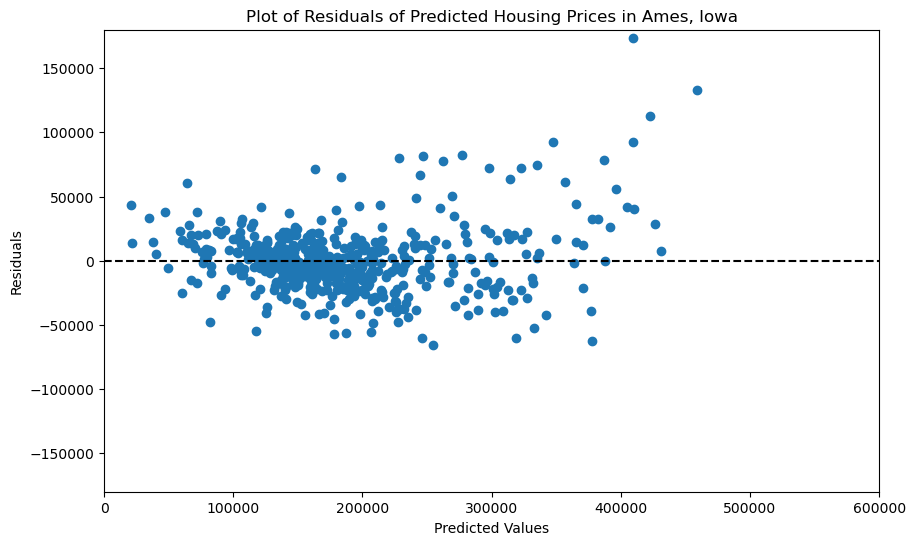

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_2_pred, reg_2_residuals)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0, 600000)
plt.ylim(-180000, 180000)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Plot of Residuals of Predicted Housing Prices in Ames, Iowa')
plt.show()


- By analyzing the residuals of my L_2 model, it looks like my residuals remain broadly random until my predicted price goes above $300K
- This could indicate that there could be another model to be done, possibly other details matter more once the houses get very nice 

In [80]:
mse_2 = mean_squared_error(y_2_test, y_2_pred)

In [81]:
rmse_2 = np.sqrt(mse_2)
rmse_2

26478.22788165334

______

## Saving Models down to be formatted properly for submission

#### Original Linear

In [82]:
lin_model_save = pd.DataFrame()
lin_model_save['variable'] = x_final_test.columns.values
lin_model_save['coefficients'] = reg.coef_
lin_model_save.loc[len(lin_model_save)] = ['intercept', reg.intercept_]

In [83]:
lin_model_save.to_csv('../datasets/Linear_Model_coef.csv')

#### Linear Model with Removed Zero-Coefficients from Lasso

In [84]:
L_2 = pd.DataFrame()
L_2['variable'] = X_2.columns.values
L_2['coefficients'] = reg_2.coef_
L_2.loc[len(lin_model_save)] = ['intercept', reg_2.intercept_]

In [85]:
L_2.to_csv('../datasets/Linear_Model_coef_2.csv')

- Following the Logic of the L_2 Model, will train the entire post-Lasso model 

### Linear Model Trained on Full Training Set

In [94]:
reg_3 = linear_model.LinearRegression()
reg_3.fit(X_2,y_2)
reg_3.score(X_2,y_2)

0.8930378392943457

In [103]:
len(X_2.columns)

83

In [182]:
cross_val_score(reg_3,X_2,y_2, cv=5).mean()

0.8515688119335444

In [88]:
L_3 = pd.DataFrame()
L_3['variable'] = X_2.columns.values
L_3['coefficients'] = reg_3.coef_
L_3.loc[len(lin_model_save)] = ['intercept', reg_3.intercept_]

In [89]:
L_3.to_csv('../datasets/Linear_Model_coef_3.csv')

#### Last-minute Ridge Model out of curiousity

In [90]:
ridge = Ridge()#alpha=alpha
ridge.fit(x_final_train, y_train)
ridge.score(x_final_train,y_train)

0.9078351443176091

In [183]:
ridge.score(x_final_test, y_test)

0.8522124697101471

In [185]:
ridge.alpha

1.0

- I saw a little overfitting evidence with Ridge. Further I was seeing stronger scores from lasso, with less evidence of overfitting
- Consequently I stuck with the model using Lasso

In [92]:
ridge_model_save = pd.DataFrame()
ridge_model_save['variable'] = x_final_train.columns.values
ridge_model_save['coefficients'] = ridge.coef_
ridge_model_save.loc[len(ridge_model_save)] = ['intercept', ridge.intercept_]

In [106]:
ridge_model_save.to_csv('../datasets/Ridge_Model_coef.csv')